# Cross-Validation Simulation
*This notebook compares the accuracy of different cross-validation strategies for estimating out-of-sample prediction error.*

## Import Dependencies

In [1]:
import numpy as np
import scipy
from collections import defaultdict
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
X, y = load_boston(return_X_y=True)

## Set up error estimation simulation

In [3]:
def estimate_mse(X, y, model, cv):
    score = cross_validate(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    return -score['test_score'].mean()

def measure_cv_accuracy(X, y, model, cvs, n, num_trials):
    result = defaultdict(list)
    for _ in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        result['test'].append(mse)
        for name, cv in cvs:
            estimated_mse = estimate_mse(X_train, y_train, model, cv)
            result[name].append(estimated_mse)
    return result

def run_simulation(X, y, model, cvs, train_sizes, num_trials):
    result = defaultdict(lambda: defaultdict(list))
    for n in train_sizes:
        for name, errors in measure_cv_accuracy(X, y, model, cvs, n, num_trials).items():
            mean = np.mean(errors)
            stddev = np.std(errors, ddof=1)
            interval = scipy.stats.t.interval(alpha=0.95, df=num_trials-1, 
                                              scale=stddev/np.sqrt(num_trials))
            result[name]['mean'].append(mean)
            result[name]['error_bar'].append(interval[1])
    return result

## Run error estimation simulation

In [4]:
np.random.seed(0)
cvs = [
    ('leave-one-out', LeaveOneOut()),
    ('5-fold', KFold(5, shuffle=True)),
    ('10-fold', KFold(10, shuffle=True)),
]
train_sizes = [50, 60, 70, 80, 90, 100]
num_trials = 2000
simulation_results = run_simulation(X, y, LinearRegression(), 
                                    cvs, train_sizes, num_trials)

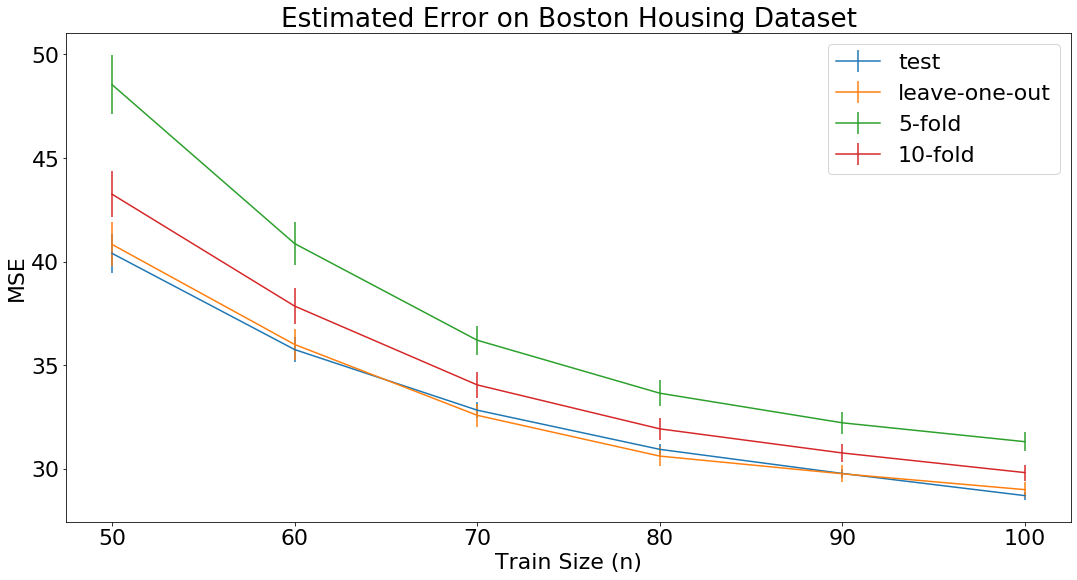

In [5]:
plt.figure(figsize=(18,9))
plt.rcParams.update({'font.size': 22})
for name, simulation_result in simulation_results.items():
    plt.errorbar(train_sizes, 
                 simulation_result['mean'], 
                 yerr=simulation_result['error_bar'], 
                 label=name)
plt.title("Estimated Error on Boston Housing Dataset")
plt.legend(loc='upper right')
plt.xlabel('Train Size (n)')
plt.ylabel('MSE')
plt.show()